## Is it a bird?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos", <br>
   Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [2]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url= 'https://duckduckgo.com/'
    res= urlread(url, data={'q':term})
    searchObj= re.search(r'vqd=([\d-]+)\&', res)
    requestUrl= url+'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls, data= set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [3]:
urls= search_images('bird photos', max_images=1)
urls[0]

'https://www.activewild.com/wp-content/uploads/2018/09/robin-common-british-birds.jpg'

Alternative :

In [ ]:
# from fastbook import *
# urls= search_images_ddg('bird photos', max_images=1)
# urls[0]

...and then download a URL and take a look at it:


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


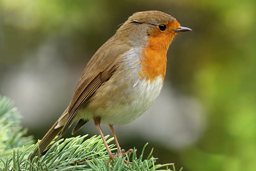

In [4]:
from fastdownload import download_url
# dest= 'bird.jpg'
# download_url(urls[0], dest)
dest= Path('bird.jpg')
if not dest.exists(): download_url(urls[0], dest, show_progress=False)


from fastai.vision.all import *
im=Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

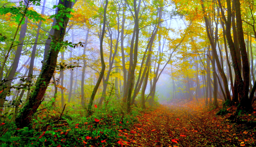

In [5]:
download_url(search_images('forest photos',max_images=1)[0],'forest.jpg',show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [6]:
searches='forest','bird'
path=Path('bird_or_not')

if not path.exists():
    for o in searches:
        dest= (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{o} photo'))
        resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model¶

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


8

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

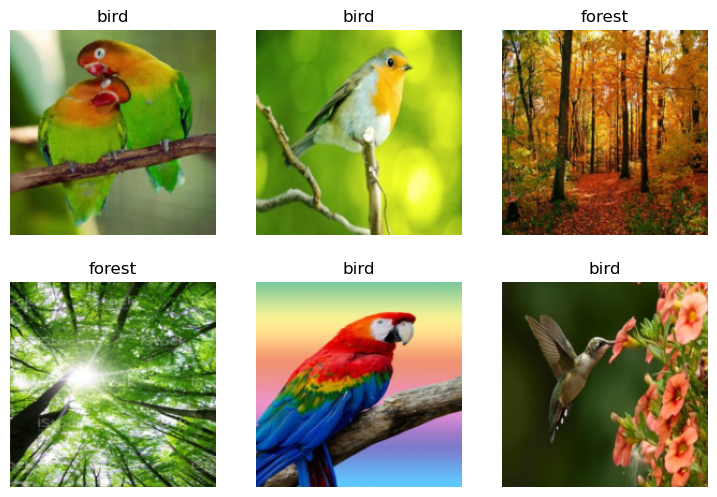

In [9]:
dls= DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [12]:
learn=vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.890836,2.166461,0.447368,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.050203,0.244594,0.092105,00:49
1,0.026992,0.023133,0.013158,00:49
2,0.020933,0.005908,0.000000,00:49


## Step 3: Use our model 

In [13]:
what_is,_,probs= learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {what_is}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
